In [1]:
import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# #source modules and classes being developed 
import package
from package.writhe.writhe import to_writhe_matrix, to_writhe_adj_matrix, Writhe
from package.gnn.writhe_graph import WritheGraph
from package.gnn.lightning_graph import GraphDataSet
from package.visualize import visualize
from package.utils import utils
from package.msmtool.msmtool import tCCA, vamp2, MarkovModel, Kmeans
from package.mdtool.mdtool import calc_sa

 # Load MDTraj Trajectory Object

In [2]:
# dcd = "./asyn/asyn_Cterm_apo.all.dcd"
# pdb = "./asyn/asyn.cterm.mae2pdb.pdb"
# protein_name = "Apo Asyn C-Term"
# out_dir = "./asyn/cterm/apo"
# sele = "protein and not resid 20"

# dcd = "./asyn/asyn_full_lig47_trunc.protein.dcd"
# pdb = "./asyn/asyn_full_lig47_trunc.protein.pdb"
# protein_name = "Full Asyn + lig47"
# out_dir = "./asyn/full/lig47"
# sele = "protein"

dcd = "/home/t/writhe/actr/ACTR-a99SBdisp-Traj.dcd"
pdb = "/home/t/writhe/actr/ACTR.pdb"
protein_name = "ACTR"
out_dir = "./ACTR"
sele = "protein and (resid 0 to 70)"

# dcd = ("/home/t/writhe/asyn/full/apo/"
#        "DESRES-Trajectory_pnas2018b-asyn-a99SBdisp-extended-protein/"
#        "pnas2018b-asyn-a99SBdisp-extended-protein/asyn_apo_full.dcd")
# pdb = "./full_length_asyn_apo.pdb"
# protein_name = "Full Length Asyn Apo"
# sele = "protein"
# out_dir = "/home/t/writhe/asyn/full/apo"
       


# dcd = "./ntail.apo.300K.dcd"
# pdb = "./ntail_apo.pdb"
# sele = "protein and (resid<21)"
# out_dir = "./ntail/apo"
# protein_name="N$_{TAIL}$"
# helix_pdb = "./Ntail.helix.pdb"

# table,bonds = md.load(pdb).topology.to_dataframe()
# table.sort_values("resSeq", inplace = True, ignore_index = True)
# top = md.Topology.from_dataframe(table, bonds)

trj = md.load(dcd, top=pdb,stride=1).center_coordinates()
trj = trj.atom_slice(trj.topology.select(sele))
residues=[str(trj.topology.residue(i)) for i in range(trj.n_residues)]

 # Compute Writhe, Generate Matrices For Visualization and Store Results In Writhe Class Instance For Plotting Later

In [3]:
#get CA coords
xyz = trj.atom_slice(trj.topology.select("name CA")).xyz
#instantiate writhe class
writhe = Writhe(xyz)
#compute writhe at segment length : 2 (uses parallelization over the cpu cores)
lengths = [2]
writhe_data = writhe.compute_writhe(length = lengths[0],
                                    matrix = True,
                                    store_results = True,
                                    return_segments=False,
                                    adj_matrix=False)

2023-09-25 12:05:21,765	INFO worker.py:1636 -- Started a local Ray instance.


 # Test Speed The Parallelized Computation

prot = md.load(utils.lsdir("/home/t/Downloads", ["7swr","pdb"])).center_coordinates()
xyz = prot.atom_slice(prot.topology.select("name CA")).xyz
writhe = Writhe(xyz)
fig, axes = plt.subplots(2,3,figsize=(15,5))
for i,ax in enumerate(axes.flat):
    writhe.compute_writhe(length=i+2, matrix=True, store_results=True)
    writhe.plot_writhe_matrix(ax=ax)

In [5]:
#test the speed of the calculation without storing and reshaping data
writhe.compute_writhe(length=2, speed_test=True)
print(f"Frame Count : {trj.n_frames}")

2023-09-25 10:03:05,581	INFO worker.py:1636 -- Started a local Ray instance.


Time elapsed : 9.792433023452759 s
Frame Count : 119921


# Use Writhe Class Plotting Functions to visualize the results.
# The make_structures and plot_structure functions generate pymol respresentations of the structures corresponding to the writhe data on the fly.

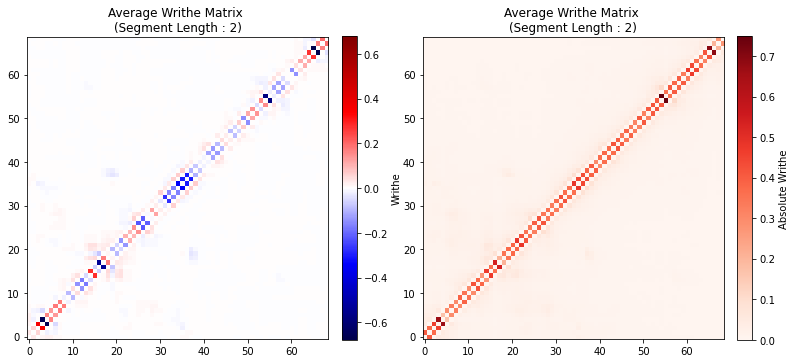

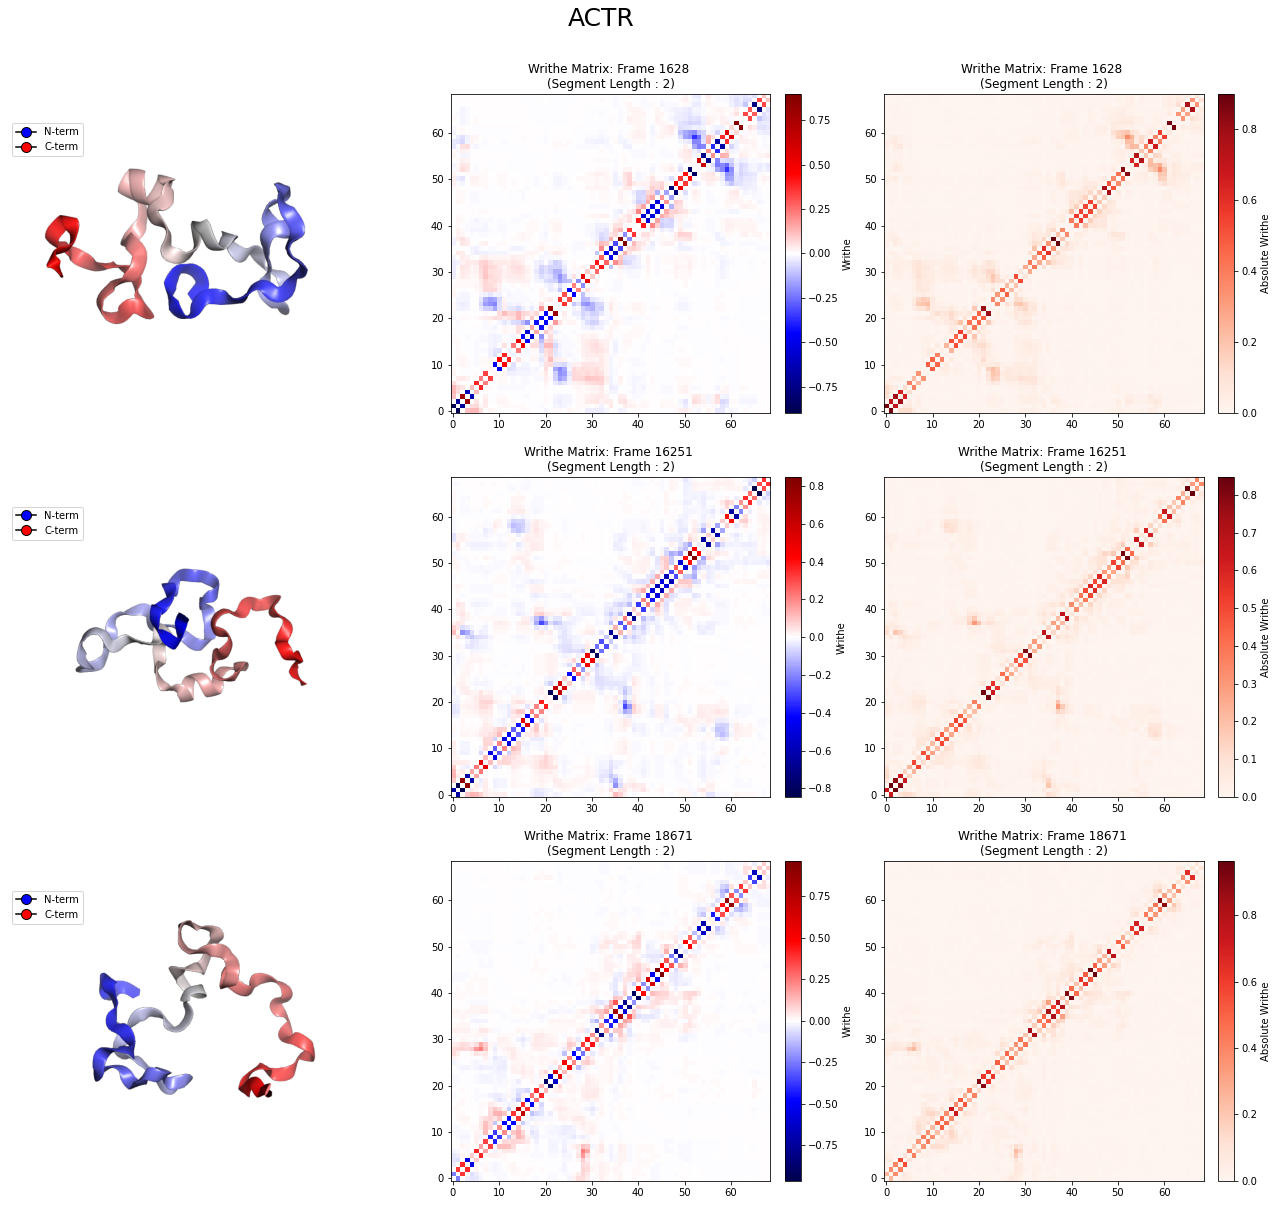

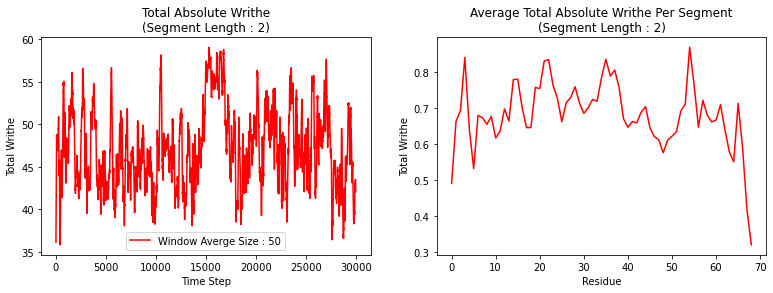

In [4]:
fig, axes = plt.subplots(1,2,figsize=(13,13))
ax=axes.flat
#plot the average 
writhe.plot_writhe_matrix(ax=ax[0])
#plot the absolute value average
writhe.plot_writhe_matrix(absolute=True,ax=ax[1])

#plot the writhe matrix at different timesteps
fig,axes=plt.subplots(3,3, figsize=(22,20))

idx=abs(writhe_data["writhe_features"]).sum(1).argsort()[::-1].astype(int)

#asyn apo c-term indices : idx[0], 168477, 34708
#indices = [idx[0], 168477, 34708]

# ACTR indices idx[[4,20]].tolist()+[idx[-15000]]
indices = idx[:3]

fig.suptitle(protein_name, fontsize=25, y=.94)
for ax, index in zip(axes, [idx[0],idx[1000],idx[2000]]):
    structure=visualize.make_structures(trj=trj, indices=int(index), dir=f"{out_dir}/images")
    visualize.plot_structure(image=structure, ax=ax[0])
    writhe.plot_writhe_matrix(index=index, ax=ax[1])
    writhe.plot_writhe_matrix(index=index, ax=ax[2], absolute=True)
    
    
#plot the total absolute writhe in a time series with a windowed average
fig, axes = plt.subplots(1,2,figsize=(13,4))
ax=axes.flat
writhe.plot_writhe_total(window=50,ax=ax[0])
#plot the average absolute writhe per segment
writhe.plot_writhe_per_segment(ax=ax[1])


# Use Same Instance To Compute and Plot Writhe Data At Different Segment Lengths

2023-09-25 12:05:38,235	INFO worker.py:1636 -- Started a local Ray instance.
2023-09-25 12:05:49,859	INFO worker.py:1636 -- Started a local Ray instance.
2023-09-25 12:06:01,321	INFO worker.py:1636 -- Started a local Ray instance.
2023-09-25 12:06:12,793	INFO worker.py:1636 -- Started a local Ray instance.
2023-09-25 12:06:24,259	INFO worker.py:1636 -- Started a local Ray instance.
2023-09-25 12:06:35,455	INFO worker.py:1636 -- Started a local Ray instance.


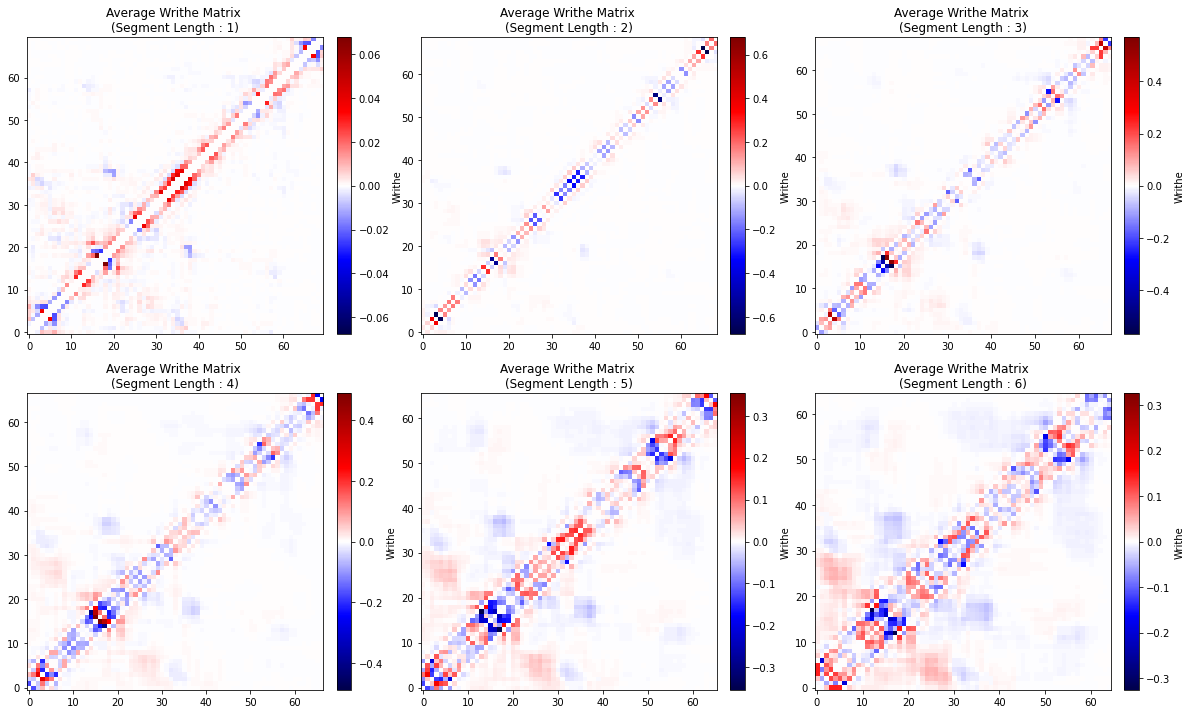

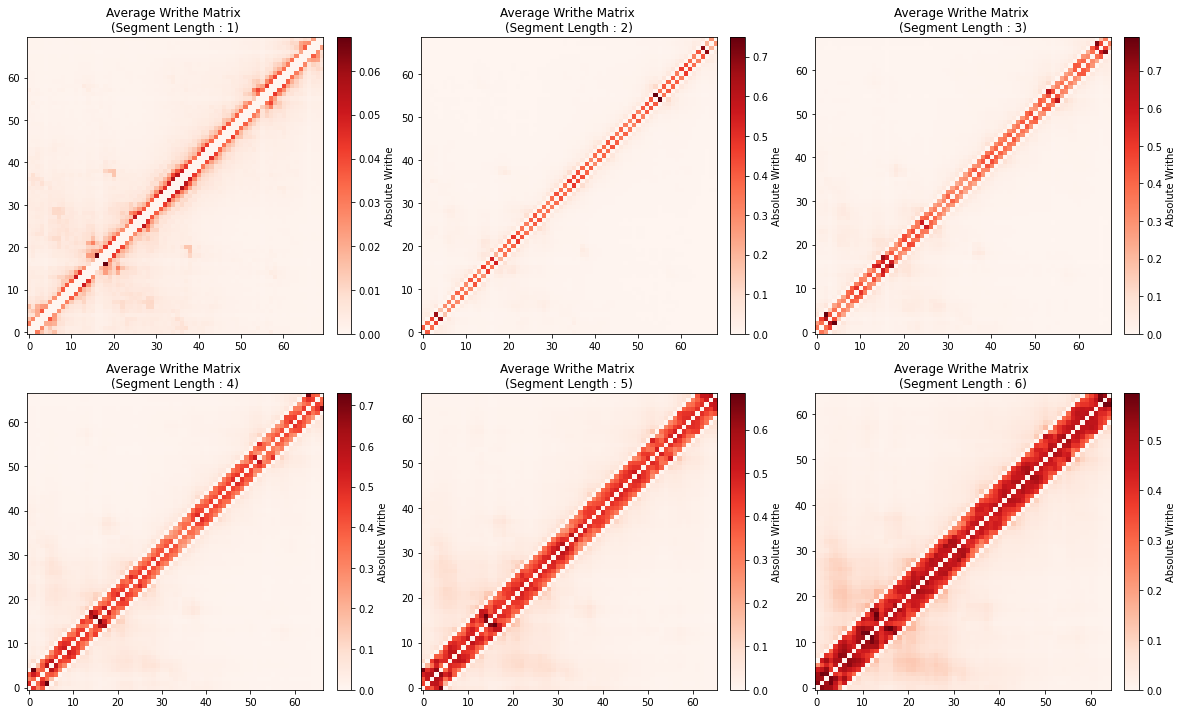

In [5]:
#compute and plot the writhe for different segment lengths
lengths+=[1,3,4,5,6]
lengths.sort()
writhe_datasets={length:{} for length in lengths}
writhe_datasets[2] = {"data":writhe.writhe_features}
fig, axes = plt.subplots(2,3, figsize=(20,12))
fig_abs, axes_abs = plt.subplots(2,3, figsize=(20,12))
for ax, ax_abs,length in zip(axes.flat, axes_abs.flat, lengths):
    writhe_data = writhe.compute_writhe(length = length,
                                         matrix = True,
                                         store_results = True,
                                        )
    writhe_datasets[length]["data"] = writhe_data["writhe_features"]
    writhe.plot_writhe_matrix(ax=ax)
    writhe.plot_writhe_matrix(ax=ax_abs,absolute=True)



# Compute the VAMP scores of writhe, intramolecular distance datasets datasets and compare 

In [6]:
#compute distances
skip_dist = 1
distances=md.compute_contacts(trj,np.stack(np.triu_indices(len(residues),skip_dist)).T)[0]
#set up dictionary to keep track of data
distance_datasets = {l:{} for l in writhe_datasets.keys()}

#compute the scores at increasing lagtimes
lags=list(range(1,102,10))
for length, dic in writhe_datasets.items():
    
    #remove distances from residue pairs "length" or less apart in sequence
    #avoid holding the intermediate distance datasets in memory
    
    distance_data=distances[:,utils.triu_flat_indices(len(residues),skip_dist,length)]
    
    #fill dictionaries with scores
    writhe_datasets[length]["scores"] = np.stack([vamp2(dic["data"], lag=lag, dim=5, sum_=False)
                                                  for lag in lags])
    
    distance_datasets[length]["scores"] = np.stack([vamp2(distance_data, lag=lag, dim=5, sum_=False)
                                                    for lag in lags])

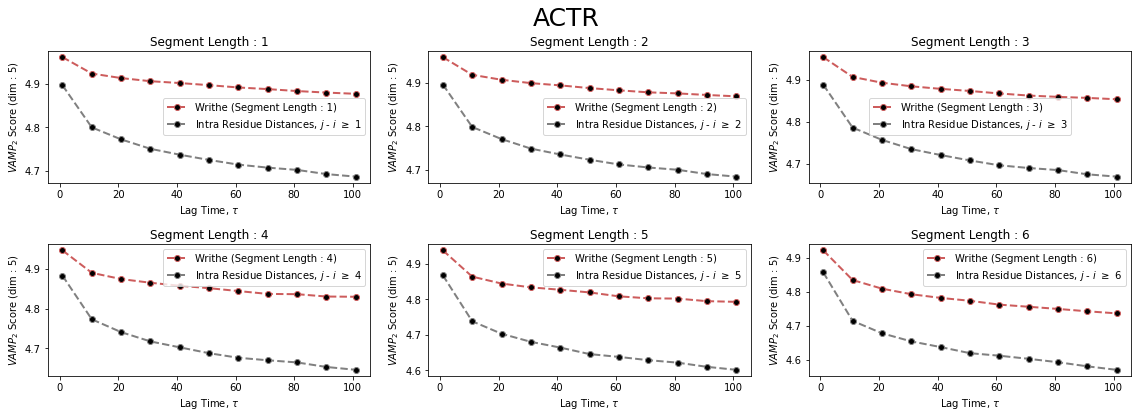

In [7]:
from matplotlib.lines import Line2D
fig,axes=plt.subplots(2,3,figsize=(16,6))

for ax,length in zip(axes.flat, lengths):
    
    ax.plot(lags,writhe_datasets[length]["scores"].sum(-1),
             label=f"Writhe (Segment Length : {length})",
             color="indianred",
             lw=2,
             ls="--",
             marker="o",
             mfc="black")
    
    
    ax.plot(lags,distance_datasets[length]["scores"].sum(-1),
             label=f"Intra Residue Distances, $j$ - $i$ $\geq$ {length}",
             color="gray",
             lw=2,
             ls="--",
             marker="o",
             mfc="black")
    

    ax.set_ylabel("$VAMP_{2}$ Score (dim : 5)")
    ax.set_xlabel(r"Lag Time, $\tau$")
    ax.set_title(f"Segment Length : {length}")
    ax.legend()
    
fig.suptitle(protein_name, fontsize=25, y=.96)
plt.tight_layout()

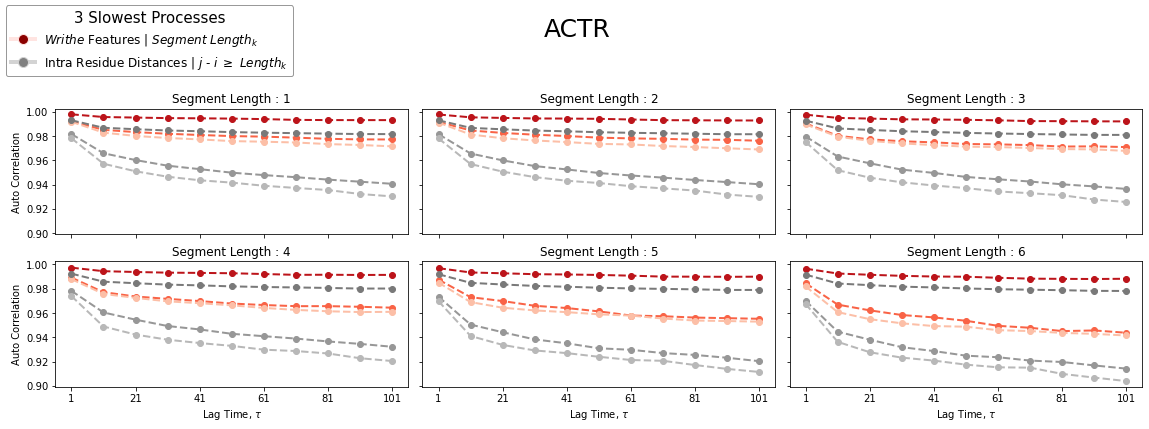

In [8]:
from cycler import cycler
n_procs=3
fig,axes=plt.subplots(2,3,figsize=(16,6),sharey=True, sharex=True)

for ax,length in zip(axes.flat, lengths):
    
    ax.set_prop_cycle((cycler(color=visualize.get_color_list(n_procs,"Reds_r",trunc=60,pre_trunc=50)
                             )))
    
    ax.plot(writhe_datasets[length]["scores"][:,:n_procs],
             label=f"Writhe (Segment Length : {length})",
             lw=2,
             ls="--",
             marker="o")
    
    
    ax.set_prop_cycle((cycler(color=visualize.get_color_list(n_procs,"Greys_r",trunc=100, pre_trunc=100)
                             )))
    
    ax.plot(distance_datasets[length]["scores"][:,:n_procs],
             label=f"Writhe Features (Segment Length : {length})",
             lw=2,
             ls="--",
             marker="o")
    
    ax.set_xticks(range(0,len(lags),2),lags[::2])

    ax.set_title(f"Segment Length : {length}")


for ax in axes[:,0]:
    ax.set_ylabel("Auto Correlation")
for ax in axes[-1]:
    ax.set_xlabel(r"Lag Time, $\tau$")
    

fig.suptitle(protein_name, fontsize=25, y=.96)

legend_elements = [Line2D([0], [0], marker="o", color='mistyrose',
                          label="$Writhe$ Features | $Segment$ $Length_{k}$",
                          markerfacecolor="darkred", markersize=10, lw=4),
                   Line2D([0], [0], marker="o", color='lightgray',
                          label='Intra Residue Distances | $j$ - $i$ $\geq$ $Length_{k}$',
                          markerfacecolor="gray", markersize=10,lw=4)]

fig.legend(handles=legend_elements,title=f"{n_procs} Slowest Processes",loc="upper left",
          fontsize=12, title_fontsize=15, edgecolor=(.5,.5,.5))

plt.tight_layout()
plt.subplots_adjust(top=.75)

 # What Segment length(s) should be used?
 
 
 
 
 
    We can plot the VAMP score as a function of the writhe segment length to determine     the optimal segment length(s) for identifying slow dynamical modes/conformational       transitions from our trajectory data.
 


Text(0.5, 1.0, 'ACTR')

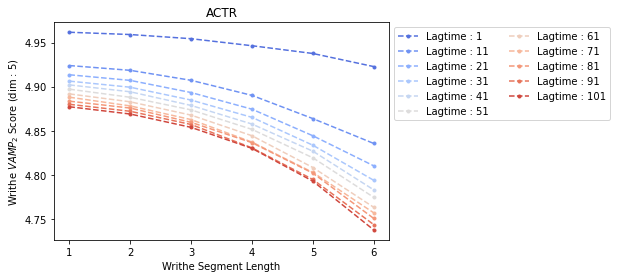

In [161]:
scores=np.stack([dic["scores"].sum(-1) for dic in writhe_datasets.values()])

for score,label,color in zip(scores.T,
                             [f"Lagtime : {lag}" for lag in range(1,102,10)],
                             visualize.get_color_list(len(lags),"coolwarm",pre_trunc=20,
                                                      trunc=20)):
    
    plt.plot(lengths,
             score,
             color=color,
             label=label,
             ls="--",
             marker="o",
             ms=3,)
#              mfc="black",
#              mec="black")
    
    
plt.xticks(range(1,lengths[-1]+1))
plt.ylabel("Writhe $VAMP_{2}$ Score (dim : 5)")
plt.xlabel(r"Writhe Segment Length")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left',ncol=2)
plt.title(protein_name)


# From the vamp score, we see which segment lengths work the best.

    When combining writhe datasets computed using different segment lengths as a means for finding an optimal input for dimensionality reduction or deep learning models, the relaxation timescales (vamp score computed at varying lagtimes) should be similar at the lagtime of the model. This is because these models generally aim to maximize the autocorrelation of the transformed data at a target lagtime.

    Given that writhe computed at different length scales probe different geometric features of a protein's topology, combining these datasets should provide a good description of the system and it's slow dynamics).

# Here, we'll combine the writhe data sets computed at a variety of segment lengths



In [57]:
combined_feature_lengths = [[1,3], [1,3,4], [1,3,5], [2,4,6]][::-1]
proj_lag = 15
proj_dim = 4

#make the combined "feature" sets
writhe_feature_sets = {}
for combine_lens in combined_feature_lengths:
    dic = {}
    data = np.concatenate([writhe_datasets[length]["data"] for length in combine_lens],axis=-1)
    dic["scores"] = np.stack([vamp2(x=data, lag=lag, sum_=False, dim = 5) for lag in lags])
    dic["proj"] = tCCA(data=data, lag=proj_lag, dim = proj_dim).fit_transform()
    writhe_feature_sets["".join(list(map(str,combine_lens)))] = dic
    

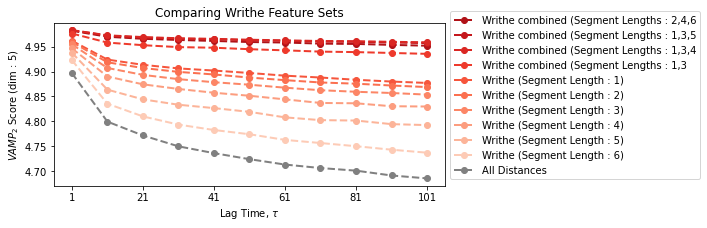

In [58]:
fig, ax = plt.subplots(1,figsize=(7,3),sharey=True, sharex=True)

ax.set_prop_cycle((cycler(color=visualize.get_color_list(10,"Reds_r",trunc=50, pre_trunc=40)
                         )))


for key, val in writhe_feature_sets.items():
    
    ax.plot(val["scores"].sum(-1),
            label=f"Writhe combined (Segment Lengths : {','.join(list(iter(key)))}",
            lw=2,
            ls="--",
            marker="o")


#plot vamp scores for writhe calculated at segment lengths used in combined feature sets
for length in set([item for sublist in combined_feature_lengths for item in sublist]):
    ax.plot(writhe_datasets[length]["scores"].sum(-1),
             label=f"Writhe (Segment Length : {length})",
             lw=2,
             ls="--",
             marker="o")


ax.plot(distance_datasets[1]["scores"].sum(-1),
         label="All Distances",
         lw=2,
         ls="--",
         marker="o", 
         color = "gray")


ax.set_ylabel("$VAMP_{2}$ Score (dim : 5)")
ax.set_xlabel(r"Lag Time, $\tau$")
ax.set_xticks(range(0,len(lags),2),lags[::2])
ax.set_title("Comparing Writhe Feature Sets")
ax.legend(bbox_to_anchor= (1,1.1), loc="upper left")

/home/t/writhe/package/visualize/visualize.py:244: RuntimeWarning: divide by zero encountered in log
  F = -np.log(arr)


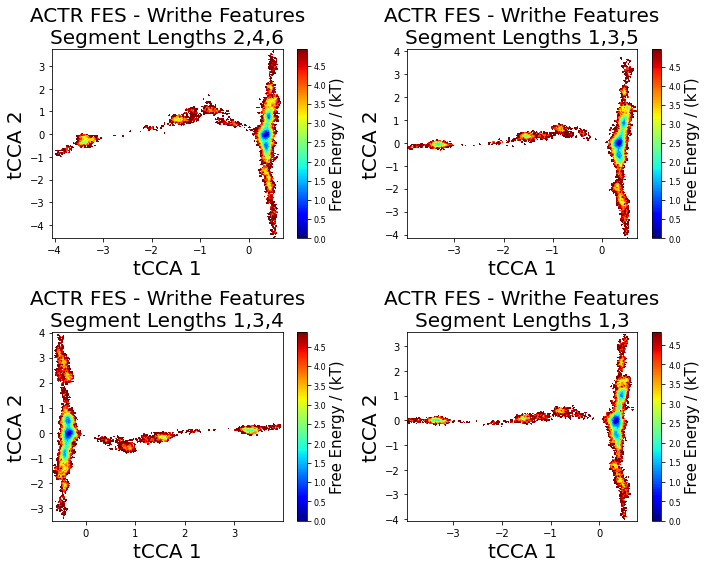

In [59]:
fig, axes = plt.subplots(2,2,figsize=(10,8))

for ax, (key, value) in zip(axes.flat, writhe_feature_sets.items()):
    visualize.fes2d(
                    value["proj"],
                    title = (f"{protein_name} FES - Writhe Features\n"
                    f"Segment Lengths {','.join(list(iter(key)))}"),
                    x_label="tCCA 1", y_label="tCCA 2",
                    ax=ax,
                    bins=250)
    
plt.tight_layout()

 # Let's project the writhe and distance data onto the dominant singular functions of their Koopman matrices

In [60]:
feat_idx = "135"
distance_projection = tCCA(
   distances[:,utils.triu_flat_indices(len(residues),1,2)], proj_lag).fit_transform(dim=proj_lag)

Text(0.48, 1, 'ACTR')

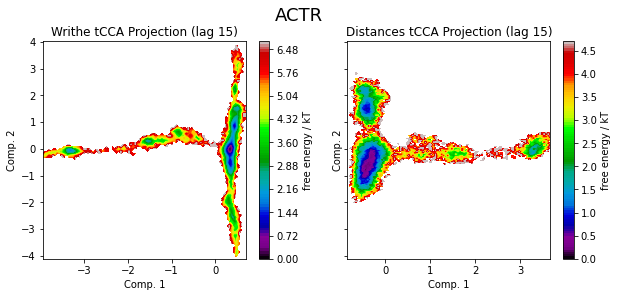

In [61]:
import pyemma
fig,axes=plt.subplots(1,2, sharey=True,figsize=(10,4))
for ax,name,data in zip(axes.flat, 
                        "Writhe,Distances".split(","),
                        [writhe_feature_sets[feat_idx]["proj"],
                        distance_projection]
                       ):
    
    ax.set_xlabel("Comp. 1")
    ax.set_ylabel("Comp. 2")
    ax.set_title(f"{name} tCCA Projection (lag {proj_lag})")
    pyemma.plots.plot_free_energy(*data[:,:2].T,ax=ax )
fig.suptitle(protein_name, fontsize=18, y=1,x=.48)

 # Clustering

In [63]:
n_clusters = 30
dtraj, frames_cl = Kmeans(writhe_feature_sets[feat_idx]["proj"], n_clusters, proj_dim)

pop_idx, counts = utils.sort_idx_list_obs(indices_list=frames_cl,
                                    obs=np.ones(trj.n_frames),
                                    stat=len,
                                    ret_stat=True).values()

populations=np.round(100*counts/trj.n_frames,2)

total_writhe_feature_set = abs(np.concatenate([writhe_datasets[int(i)]["data"]
                                              for i in iter(feat_idx)], axis=1)).sum(1)

wr_frames_cl, wr_cl_idx, wr_cl_mean = utils.sort_idx_list_obs(indices_list=frames_cl,
                                                              obs=total_writhe_feature_set,
                                                              sort_indices=True,
                                                              ret_stat=True).values()
sa = calc_sa(trj, "./ACTR.helix.pdb")
sa_frames_cl, sa_cl_idx, sa_cl_mean = utils.sort_idx_list_obs(indices_list=frames_cl,
                                                              obs=sa.sum(1),
                                                              sort_indices=True,
                                                              ret_stat=True).values()

/home/t/writhe/package/visualize/visualize.py:244: RuntimeWarning: divide by zero encountered in log
  F = -np.log(arr)


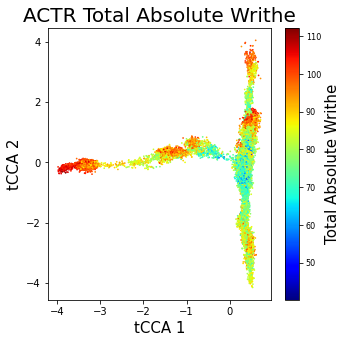

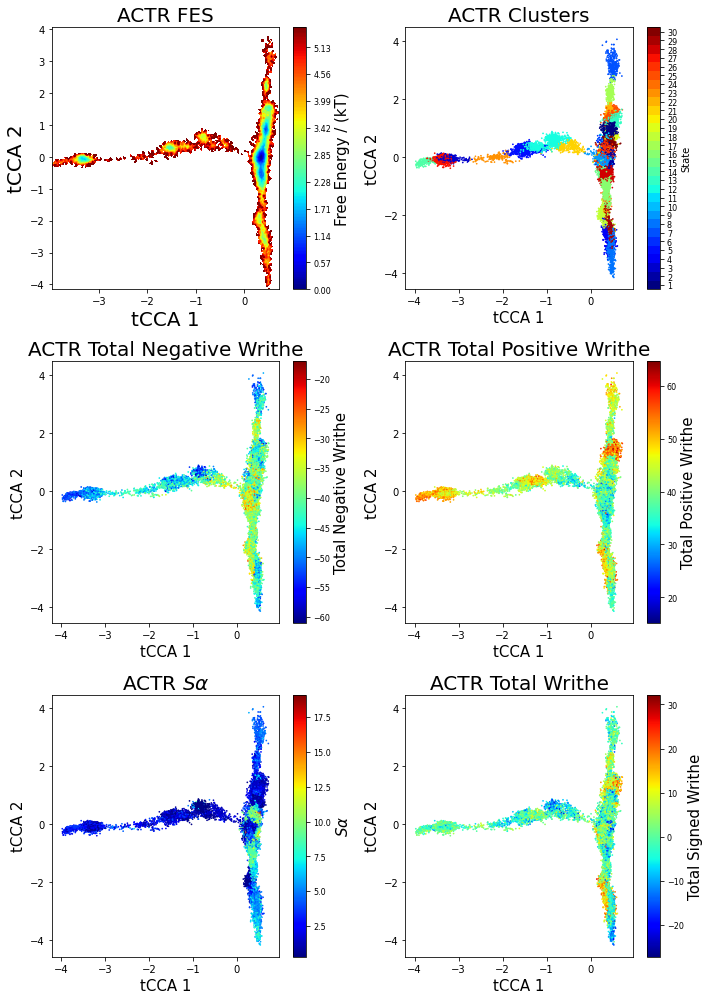

In [64]:
# set the length to use for projections
len_idx=3

#plot the total absolute writhe
visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 abs(writhe_datasets[len_idx]["data"]).sum(1),
                 title = f"{protein_name} Total Absolute Writhe",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label="Total Absolute Writhe",)


#subplot for state map, FES, variations of writhe
fig, axes = plt.subplots(3,2,figsize=(10,14))
ax=axes.flat

visualize.fes2d(writhe_feature_sets[feat_idx]["proj"],
     title = f"{protein_name} FES",
     x_label="tCCA 1", y_label="tCCA 2",
     ax=ax[0])


visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 dtraj, state_map=True,
                 title = f"{protein_name} Clusters",
                 x_label="tCCA 1", y_label="tCCA 2",
                 ax=ax[1])


visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 np.where(writhe_datasets[len_idx]["data"]<=0,
                          writhe_datasets[len_idx]["data"],0).sum(1),
                 title = f"{protein_name} Total Negative Writhe",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label="Total Negative Writhe",
                 ax=ax[2])


visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 np.where(writhe_datasets[len_idx]["data"]>=0,
                          writhe_datasets[len_idx]["data"],0).sum(1),
                 title = f"{protein_name} Total Positive Writhe",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label="Total Positive Writhe",
                 ax=ax[3])



visualize.proj2d(writhe_feature_sets[feat_idx]["proj"], sa.sum(1),
                 title = rf"{protein_name} $S\alpha$",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label=r"$S\alpha$",
                 ax=ax[4])

visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 writhe_datasets[len_idx]["data"].sum(1),
                 title = f"{protein_name} Total Writhe",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label="Total Signed Writhe",
                 ax=ax[5])
plt.tight_layout()

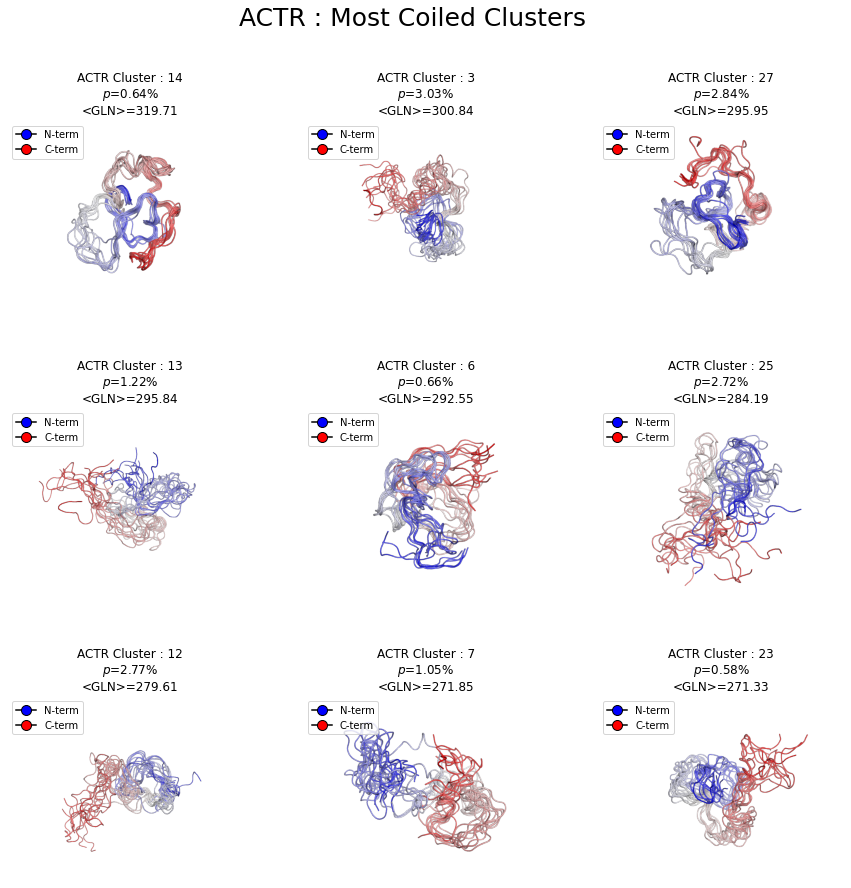

In [65]:
n_closest = 10
palette = "blue_gray90_red"
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]

fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Coiled Clusters", fontsize=25, y=.96)
for i, wr, pop, ax, indices in zip(wr_cl_idx,
                                      wr_cl_mean[wr_cl_idx],
                                      populations[wr_cl_idx],
                                      axes.flat, 
                                      list(map(wr_frames_cl.__getitem__, wr_cl_idx)),
                                      ):

    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=palette,
                                      ref=pdb)

    visualize.plot_structure(image,
                             nterm_color=nterm_color,
                             cterm_color =cterm_color,
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"
                                      "\n"
                                      rf"<GLN>={wr:.2f}"),
                             ax=ax)
    


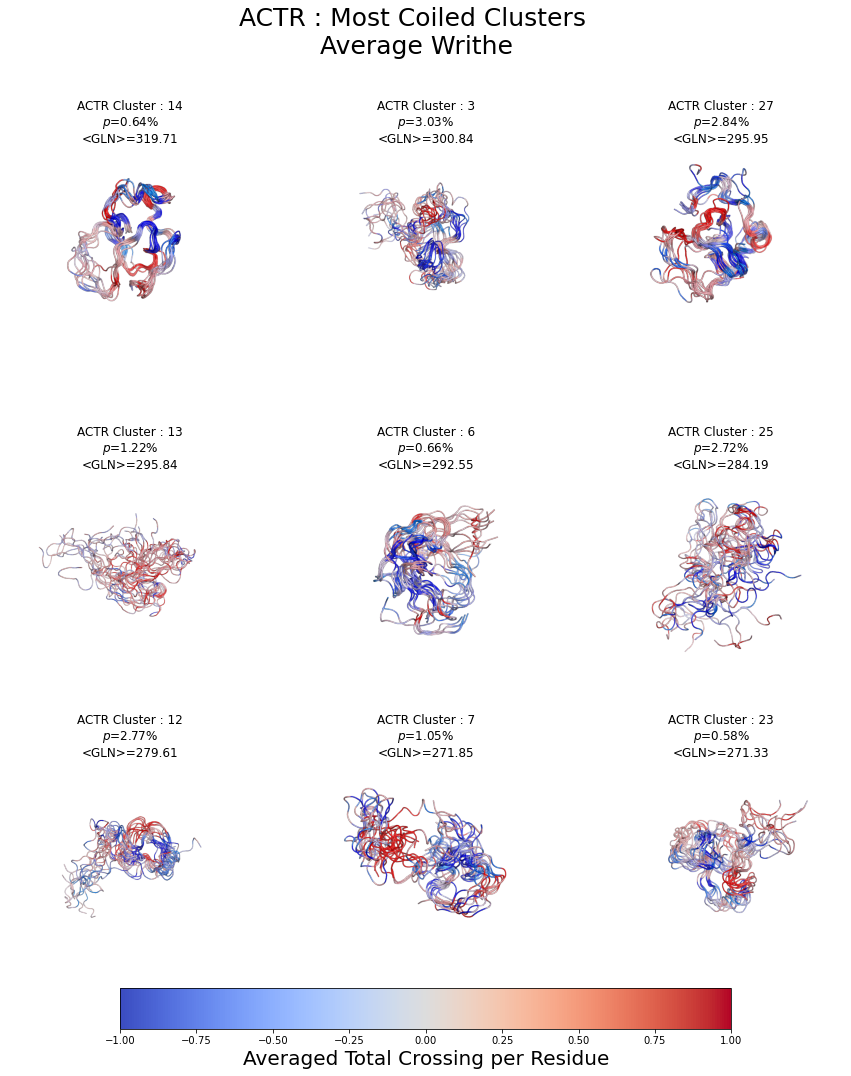

In [95]:
n_closest = 10
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]
key = "coolwarm"


fig, axes  = plt.subplots(3,3,figsize=(15,17))
fig.suptitle(f"{protein_name} : Most Coiled Clusters\n Average Writhe", fontsize=25, y=.96)
for i, wr, pop, ax, indices in zip(wr_cl_idx,
                                       wr_cl_mean[wr_cl_idx],
                                       populations[wr_cl_idx],
                                       axes.flat, 
                                       list(map(wr_frames_cl.__getitem__, wr_cl_idx))):

    beta_values = to_writhe_adj_matrix(
        writhe_datasets[len_idx]["data"][indices[:n_closest]], len(residues), len_idx).mean(0).sum(0)
    
    
    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.1,
                                      palette=visualize.palettes[key],
                                      ref=pdb,
                                      beta_values=beta_values,
                                      beta_min = -1,
                                      beta_max = 1)

    im = visualize.plot_structure(image,
                             cmap=None,
                             vmin=beta_values.min(),
                             vmax=beta_values.max(),
                             legend=False,
                             cbar_label = "Ave. Total Total Writhe",
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"
                                      "\n"
                                      rf"<GLN>={wr:.2f}"),
                             ax=ax)
cmap = getattr(plt.cm, "coolwarm")
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar = fig.colorbar(im,ax=[axes[-1,i] for i in range(3)],
                    cmap=cmap, norm=norm, 
                    orientation = "horizontal",
                    aspect=15)
cbar.set_label("Averaged Total Crossing per Residue", size = 20) 
plt.show()

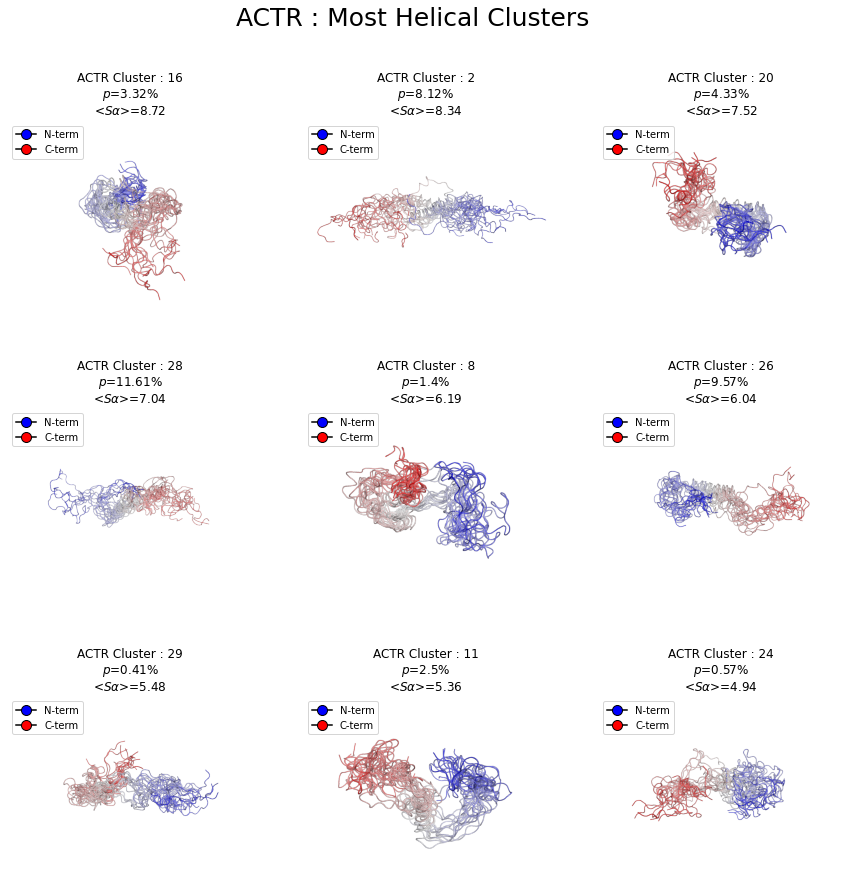

In [96]:
n_closest = 15
palette = "blue_gray90_red"
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]

fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Helical Clusters", fontsize=25, y=.96)
for i,salpha, pop, ax, indices in zip(sa_cl_idx,
                                      sa_cl_mean[sa_cl_idx],
                                      populations[sa_cl_idx],
                                      axes.flat, 
                                      list(map(sa_frames_cl.__getitem__, sa_cl_idx)),
                               ):

    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=palette,
                                      ref=pdb)

    visualize.plot_structure(image,
                             nterm_color=nterm_color,
                             cterm_color =cterm_color,
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"
                                      "\n"
                                      rf"<$S\alpha$>={salpha:.2f}"),
                             ax=ax)
    


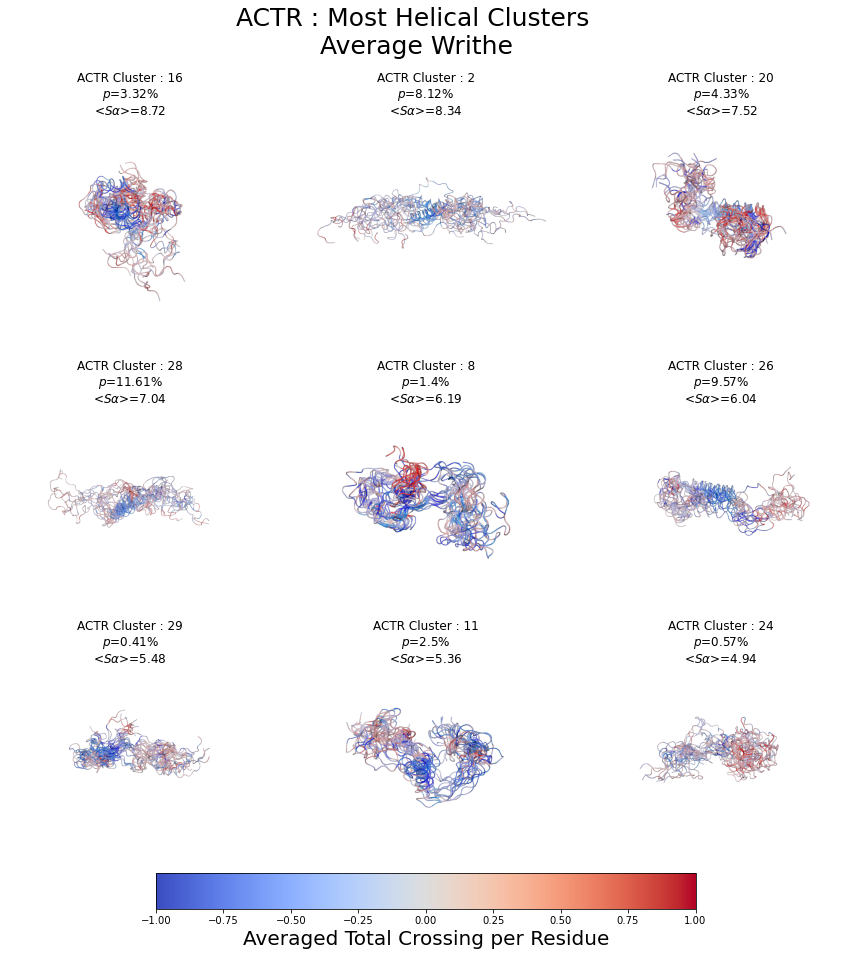

In [97]:
n_closest = 15
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]
key = "coolwarm"


fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Helical Clusters\n Average Writhe", fontsize=25, y=.96)
for i, salpha, pop, ax, indices in zip(sa_cl_idx,
                               sa_cl_mean[sa_cl_idx],
                               populations[sa_cl_idx],
                               axes.flat, 
                               list(map(sa_frames_cl.__getitem__, sa_cl_idx))):

    beta_values = to_writhe_adj_matrix(
        writhe_datasets[len_idx]["data"][indices[:n_closest]], len(residues), len_idx).mean(0).sum(0)
    
    
    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=visualize.palettes[key],
                                      ref=pdb,
                                      beta_values=beta_values,
                                      beta_min = -1,
                                      beta_max = 1)

    im=visualize.plot_structure(image,
                             cmap=None,
                             vmin=beta_values.min(),
                             vmax=beta_values.max(),
                             legend=False,
                             cbar_label = "Ave. Total Total Writhe",
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"
                                      "\n"
                                      rf"<$S\alpha$>={salpha:.2f}"),
                             ax=ax)
cmap = getattr(plt.cm, "coolwarm")
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar = fig.colorbar(im,ax=[axes[-1,i] for i in range(3)],
                    cmap=cmap, norm=norm, 
                    orientation = "horizontal",
                    aspect=15)
cbar.set_label("Averaged Total Crossing per Residue", size = 20) 
plt.show()

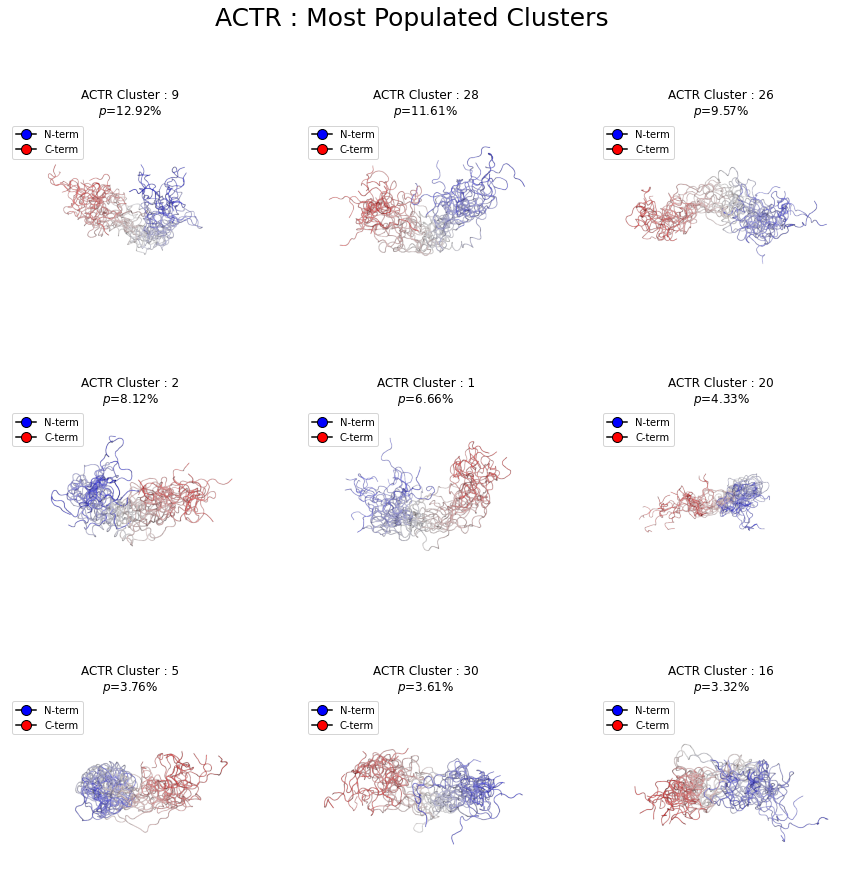

In [98]:
n_closest = 15
palette = "blue_gray90_red"
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]

fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Populated Clusters", fontsize=25, y=.96)
for i, pop, ax, indices in zip(pop_idx,
                               populations[pop_idx],
                               axes.flat, 
                               list(map(frames_cl.__getitem__, pop_idx)),
                              ):

    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=palette,
                                      ref=pdb)

    visualize.plot_structure(image,
                             nterm_color=nterm_color,
                             cterm_color =cterm_color,
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"),
                             ax=ax)

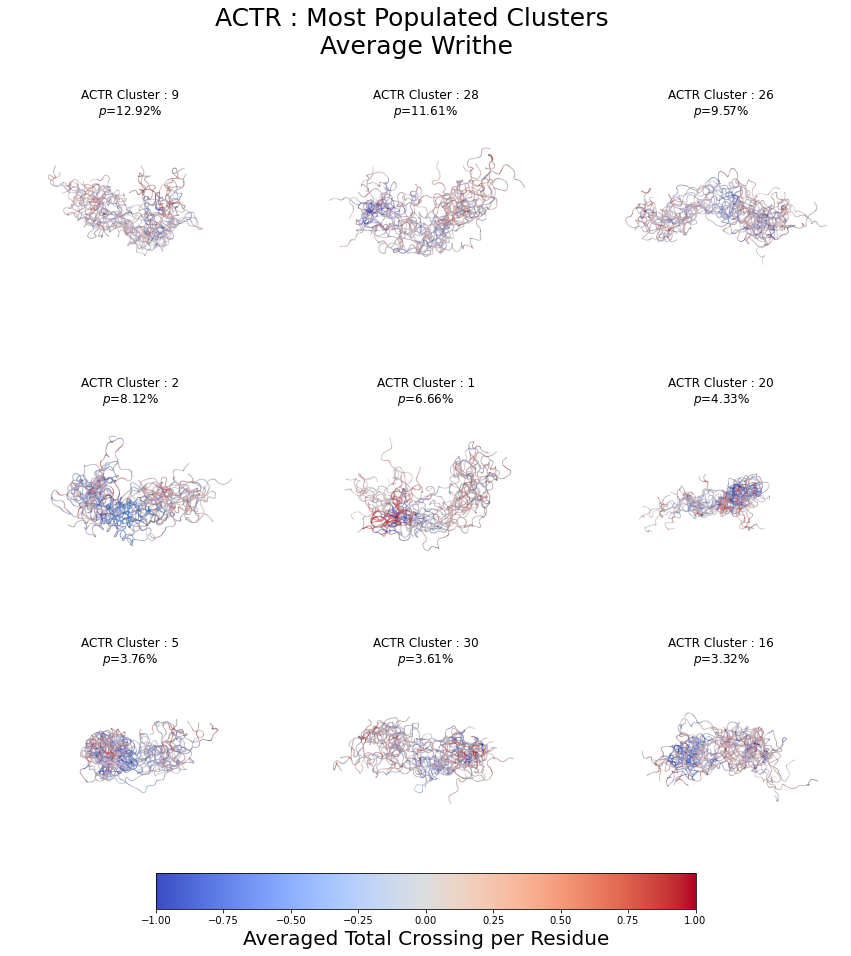

In [99]:
n_closest = 15
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]
key = "coolwarm"


fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Populated Clusters\n Average Writhe", fontsize=25, y=.96)
for i, pop, ax, indices in zip(pop_idx,
                               populations[pop_idx],
                               axes.flat, 
                               list(map(frames_cl.__getitem__, pop_idx)),
                              ):

    beta_values = to_writhe_adj_matrix(
        writhe_datasets[len_idx]["data"][indices[:n_closest]], len(residues), len_idx).mean(0).sum(0)
    
    
    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=visualize.palettes[key],
                                      ref=pdb,
                                      beta_values=beta_values,
                                      beta_min = -1,
                                      beta_max = 1)

    im = visualize.plot_structure(image,
                             cmap=None,
                             vmin=beta_values.min(),
                             vmax=beta_values.max(),
                             legend=False,
                             cbar_label = "Ave. Total Total Writhe",
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"),
                             ax=ax)
cmap = getattr(plt.cm, "coolwarm")
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar = fig.colorbar(im,ax=[axes[-1,i] for i in range(3)],
                    cmap=cmap, norm=norm, 
                    orientation = "horizontal",
                    aspect=15)
cbar.set_label("Averaged Total Crossing per Residue", size = 20) 
plt.show()

In [130]:
msm=MarkovModel(dtraj).estimate_msm(lag = 5, steps=10)

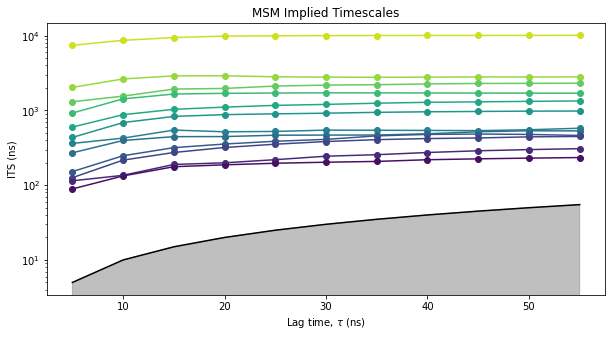

In [131]:
msm.its(model_type = "msm", n_its=12)

In [198]:
msm.estimate_msm(lag=30).estimate_hmm(9).estimate_pcca(9)

/home/t/writhe/package/msmtool/msmtool.py:694: UserWarning: Requested coarse-grained model with 9 metastable states at lag=30. The ratio of relaxation timescales between 9 and 10 states is only 1.1410552622382146 while we recommend at least 1.5. It is possible that the resulting HMM is inaccurate. Handle with caution.
  self.hmm["msms"] = list(map(lambda msm: msm.hmm(self.dtraj, n_states), self.msm["msms"]))
/home/t/writhe/package/msmtool/msmtool.py:694: UserWarning: Requested coarse-grained model with 9 metastable states at lag=60. The ratio of relaxation timescales between 9 and 10 states is only 1.1641818036836136 while we recommend at least 1.5. It is possible that the resulting HMM is inaccurate. Handle with caution.
  self.hmm["msms"] = list(map(lambda msm: msm.hmm(self.dtraj, n_states), self.msm["msms"]))
/home/t/writhe/package/msmtool/msmtool.py:694: UserWarning: Requested coarse-grained model with 9 metastable states at lag=90. The ratio of relaxation timescales between 9 and 

Text(0.5, 1.2, 'ACTR')

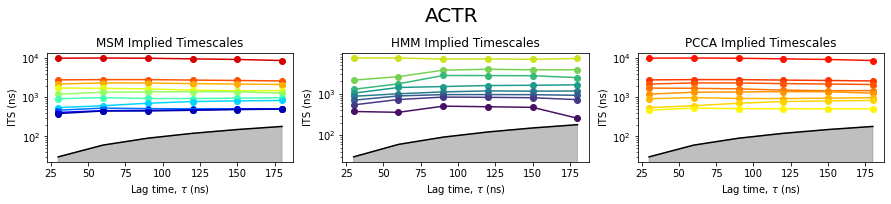

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [199]:
fig, axes = plt.subplots(1,3, figsize=(15,2))
cmaps = ["jet", "viridis", "autumn_r"]
for model, ax, cmap in zip("msm,hmm,pcca".split(","), axes.flat, cmaps):
    if model == "msm":
        n_its = 10
    else:
        n_its = None
    plt.figure()
    msm.its(model_type= model,
            ax=ax,
            n_its = n_its, 
            cmap=cmap)
plt.tight_layout()
fig.suptitle(protein_name,y=1.2, size=20)

Text(0.5, 1.2, 'ACTR')

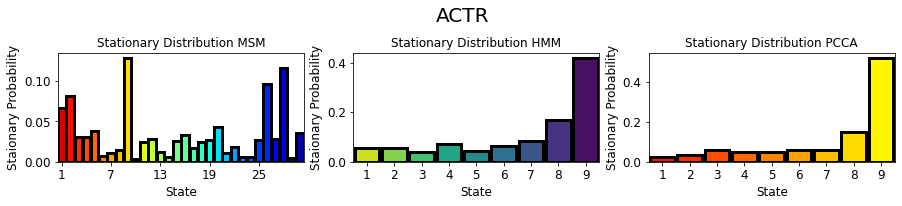

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [200]:
fig, axes = plt.subplots(1,3, figsize=(15,2))
for model, ax,cmap in zip("msm,hmm,pcca".split(","), axes.flat, cmaps):
    plt.figure()
    if model == "msm":
        state_label_stride = 6
    else:
        state_label_stride = 1
    msm.stationary_distribution(model_type= model,
                                ax=ax,
                                cmap=cmap,
                                state_label_stride=state_label_stride)
plt.tight_layout()
fig.suptitle(protein_name,y=1.2, size=20)

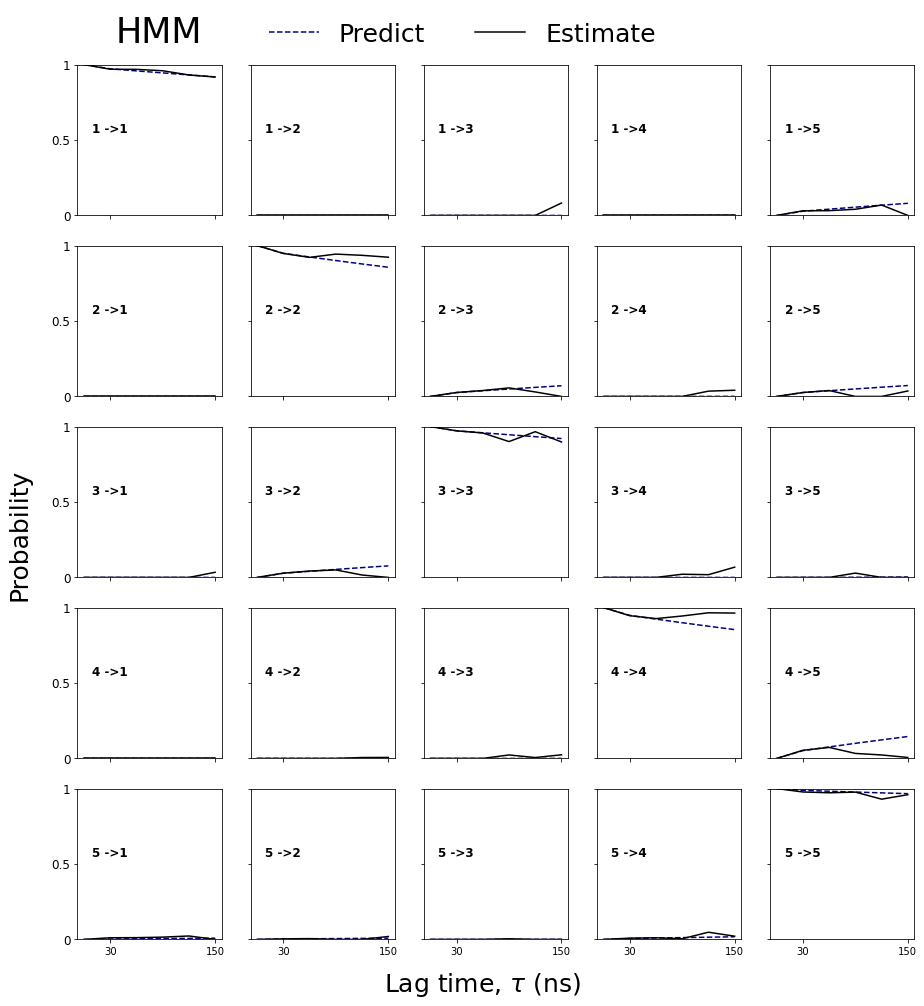

In [196]:
msm.cktest("hmm", predict_color = "navy")

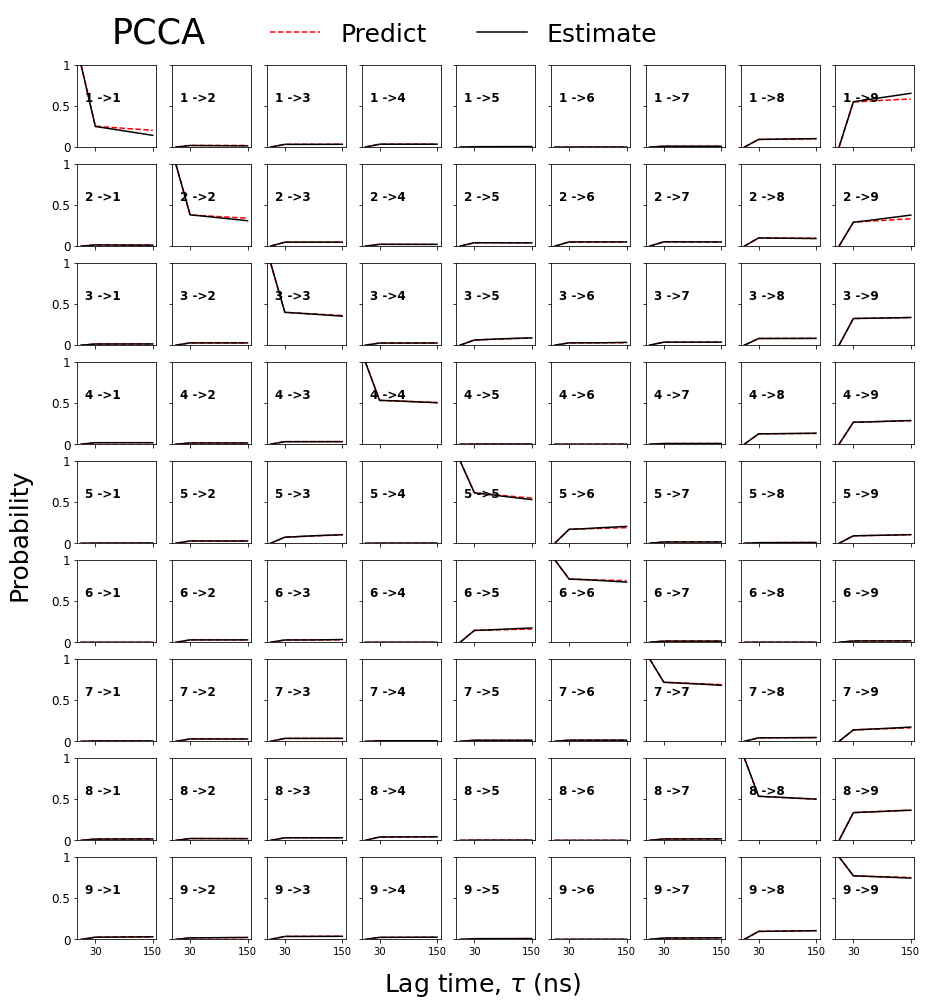

In [197]:
msm.cktest("pcca")

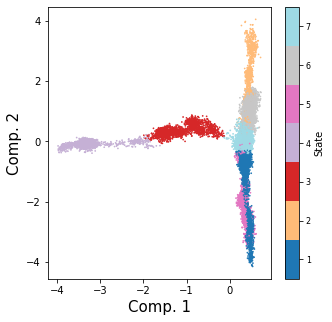

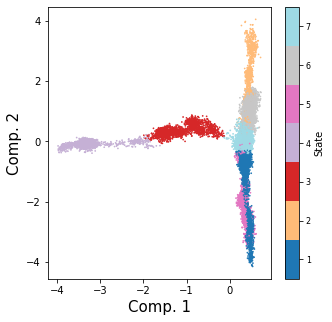

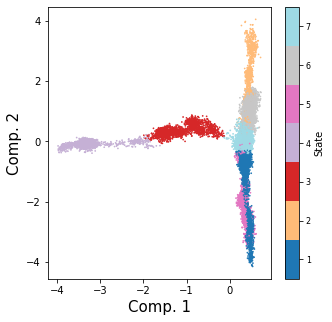

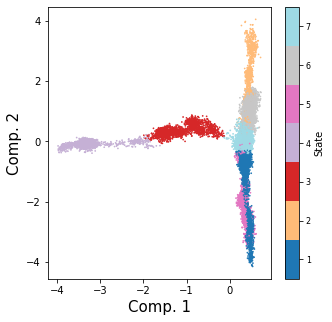

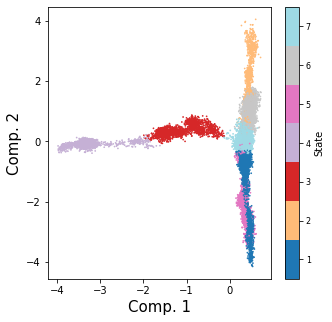

In [145]:
#msm.reindex_msm(model_type = "hmm")
for i in range(5):
    visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                     c = msm.hmm["data"]["dtrajs"][0],
                     state_map=True,
                     cmap="tab20"
                     title="HMM State Map, lag {}")